<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    #!pip install --q pycaret

    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
import warnings
import random
import os
import gc
import torch
import math
import sklearn.exceptions
import datetime
import shap
import glob

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import lightgbm          as lgb
import scikitplot        as skplt

In [4]:
from sklearn.model_selection import train_test_split,  KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler, Normalizer 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer, LabelEncoder
from sklearn.impute          import SimpleImputer
from sklearn                 import metrics
from sklearn.calibration     import CalibrationDisplay

## 1.3. Funções

In [5]:
def jupyter_setting():
    
    %matplotlib inline
      
    #os.environ["WANDB_SILENT"] = "true" 
    #plt.style.use('bmh') 
    #plt.rcParams['figure.figsize'] = [20,15]
    #plt.rcParams['font.size']      = 13
     
    pd.options.display.max_columns = None
    #pd.set_option('display.expand_frame_repr', False)

    warnings.filterwarnings(action='ignore')
    warnings.simplefilter('ignore')
    warnings.filterwarnings('ignore')
    warnings.filterwarnings('ignore', category=DeprecationWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)
    warnings.filterwarnings('ignore', category=RuntimeWarning)
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
    warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

    pd.set_option('display.max_rows', 200)
    pd.set_option('display.max_columns', 500)
    pd.set_option('display.max_colwidth', None)

    icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
    #sns.palplot(sns.color_palette(icecream))
    
    colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
          "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
          "lightskyblue", "sandybrown", "yellowgreen", "indianred",
          "lightsteelblue", "mediumorchid", "deepskyblue"]
    
    # Colors
    dark_red   = "#b20710"
    black      = "#221f1f"
    green      = "#009473"
    myred      = '#CD5C5C'
    myblue     = '#6495ED'
    mygreen    = '#90EE90'    
    color_cols = [myred, myblue,mygreen]
    
    return icecream, colors, color_cols

icecream, colors, color_cols = jupyter_setting()

In [6]:
def plot_roc_curve(fpr, tpr, label=None):
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, "r-", label=label)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.rcParams['font.size'] = 12
    plt.title('ROC curve for {}'.format(label))
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.grid(True)

In [7]:
def diff(t_a, t_b):
    from dateutil.relativedelta import relativedelta
    t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
    return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

## 1.4. Criar estrutura de pasta 

In [8]:
path        = '/content/drive/MyDrive/kaggle/Tabular Playground Series/05 - Maio/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'target'
path_automl = 'automl/'

In [9]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

for p in paths:
    try:
        os.mkdir(path + p)       
    except:
        pass 

## 1.5. Dataset

### 1.5.2. Carregar Dados

In [20]:
train_df = pd.read_csv("Data/train.csv")
test_df  = pd.read_csv("Data/test.csv")
submission_csv = pd.read_csv("Data/sample_submission.csv")

### 1.5.3. Visualizar os dados 

In [21]:
train_df.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30,target
0,0,-1.373246,0.238887,-0.243376,0.567405,-0.647715,0.839326,0.113133,1,5,1,3,3,3,1,6,1,0,7,4,0.298218,-0.919717,3.058541,-2.540739,0.766952,-2.730628,-0.208177,1.363402,ABABDADBAB,67.609153,0,0,0
1,1,1.697021,-1.710322,-2.230332,-0.545661,1.113173,-1.552175,0.447825,1,3,4,0,2,3,0,1,0,4,6,0,-3.147667,-1.075434,2.179050,2.278315,-0.633658,-1.217077,-3.782194,-0.058316,ACACCADCEB,377.096415,0,0,1
2,2,1.681726,0.616746,-1.027689,0.810492,-0.609086,0.113965,-0.708660,1,0,2,6,6,4,3,1,2,2,1,4,2.820733,-3.485342,-0.784235,-1.385775,-0.520558,-0.009121,2.788536,-3.703488,AAAEABCKAD,-195.599702,0,2,1
3,3,-0.118172,-0.587835,-0.804638,2.086822,0.371005,-0.128831,-0.282575,3,2,1,0,1,6,4,2,3,3,0,3,1.081084,-2.100177,-2.343819,0.572594,-1.653213,1.686035,-2.533098,-0.608601,BDBBAACBCB,210.826205,0,0,1
4,4,1.148481,-0.176567,-0.664871,-1.101343,0.467875,0.500117,0.407515,3,3,0,4,3,0,6,0,3,3,1,0,-0.126179,0.605033,1.133665,-3.912929,-1.430366,2.127649,-3.306784,4.371371,BDBCBBCHFE,-217.211798,0,1,1


In [22]:
test_df.head()

,id,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_27,f_28,f_29,f_30
0,900000,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,0,0,5,1,1,2,2,0,1,-1.128371,2.749347,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,BAAABADLAC,99.478419,0,0
1,900001,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,0,2,1,3,0,0,0,2,0,-4.424098,1.080762,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,AFABBAEGCB,-65.993825,1,0
2,900002,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,4,1,1,3,2,2,4,1,0,3,-1.523864,-1.406712,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,BBACABBKEE,-87.405622,0,1
3,900003,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,4,2,1,5,0,3,3,1,4,2,-1.404597,3.011085,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,AEBEAACQCC,-281.293460,0,0
4,900004,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,2,0,0,3,0,1,2,0,2,2,-1.968516,0.100594,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,AEBBBBDABF,25.629415,0,2


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. FEATURE ENGINEERING </h1>    
</div>



Nesta parte do processo vamos criar diversas variávies com o intuito de ajudar o modelo a identificar novos padrões e consequentemente melhor o desempenho, como padrão vamos criar todas as variáveis com inicial **fe_**, a cada criação de novas variáveis vamos treinar o modelo __XGBoost__ e analisar a performance das novas variáveis na identifição de novos padrões.

In [23]:
# function to create features from f27 column
def create_features(data):
    
    # create unique column names
    object_data_cols = [f"f_27_{i+1}" for i in range(10)]
    # create dataframe that has column names created above and seperates each letter into its own column
    object_data = pd.DataFrame(data['f_27'].apply(list).tolist(), columns=object_data_cols)
    
    # turn each letter into a number
    for feature in object_data_cols:
        object_data[feature] = object_data[feature].apply(ord) - ord('A')
    
    # concaatanete the original dataframe with the new dataframe created above
    data = pd.concat([data, object_data], axis=1)
    
    # create a column called unique_characters which counts the number of unique numbers in each row between
    # column f_27_0 and f_27_10
    data["unique_characters"] = data.f_27.apply(lambda s: len(set(s)))
    
    data['fe_02_21']      = (data.f_21 + data.f_02 > 5.2).astype(int) - (data.f_21 + data.f_02 < -5.3).astype(int)
    data['fe_05_22']      = (data.f_22 + data.f_05 > 5.1).astype(int) - (data.f_22 + data.f_05 < -5.4).astype(int)
    i_00_01_26            = data.f_00 + data.f_01 + data.f_26    
    data['fe_i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
    data.drop(["id","f_27",], axis=1, inplace=True)
    
    # return dataframe
    return data

In [24]:
train_df = create_features(train_df)
test_df  = create_features(test_df)
train_df.shape, test_df.shape

((900000, 42), (700000, 41))

In [25]:
# remove id, f27, target from prodictor variables 
x_train = train_df.drop(["target"],axis=1)

# make target dependet variable
y_train = train_df["target"]

# remove id, f27 from validation data
x_test = test_df

In [26]:
# view a couple of rows from validation data
x_test.head()

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_14,f_15,f_16,f_17,f_18,f_19,f_20,f_21,f_22,f_23,f_24,f_25,f_26,f_28,f_29,f_30,f_27_1,f_27_2,f_27_3,f_27_4,f_27_5,f_27_6,f_27_7,f_27_8,f_27_9,f_27_10,unique_characters
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,0,0,5,1,1,2,2,0,1,-1.128371,2.749347,-1.006400,-1.193879,-2.435736,-2.427430,-1.966887,5.734205,99.478419,0,0,1,0,0,0,1,0,3,11,0,2,5
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,0,2,1,3,0,0,0,2,0,-4.424098,1.080762,2.382405,0.149442,1.883322,-2.848714,-0.725155,3.194219,-65.993825,1,0,0,5,0,1,1,0,4,6,2,1,6
2,0.303990,2.445110,0.246515,0.818248,0.359731,-1.331845,1.358622,3,3,4,1,1,3,2,2,4,1,0,3,-1.523864,-1.406712,-7.026098,1.312277,-5.157192,1.714005,0.585032,0.066898,-87.405622,0,1,1,1,0,2,0,1,1,10,4,4,5
3,0.154053,0.260126,-1.367092,-0.093175,-1.111034,-0.948481,1.119220,0,0,4,2,1,5,0,3,3,1,4,2,-1.404597,3.011085,-0.594532,-3.939475,1.754570,-2.364007,-1.003320,3.893099,-281.293460,0,0,0,4,1,4,0,0,2,16,2,2,5
4,-1.651904,-0.424266,-0.667356,-0.322124,-0.089462,0.181705,1.784983,2,2,2,0,0,3,0,1,2,0,2,2,-1.968516,0.100594,0.084906,-0.985736,-0.130467,-3.557893,1.210687,1.861884,25.629415,0,2,0,4,1,1,1,1,3,0,1,5,5


<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. VALIDAÇÃO CRUZADA </h1>    
</div>

## 3.1. Modelagem

In [27]:
X      = train_df.drop([target], axis=1).copy()
y      = train_df[target]
X_test = x_test

In [28]:
%%time 

n_splits     = 5     
folds        = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=12359)
folds        = folds.split(X, y, groups=y)
scaler       = QuantileTransformer(output_distribution='normal', random_state=0)
seed         = 12359
eval_metric  = ['auc', 'error']                 
n_estimators = 1000 
score        = []      
score_lloss  = []


y_pred_test_prob_oof = 0      
time_fold_start      = datetime.datetime.now()
taco                 = 76 
string_scaler        = str(scaler)        
string_scaler        = string_scaler[:string_scaler.index('(')]

params = {'objective'        : 'binary:logistic',   
          'eval_metric'      : eval_metric,
          'n_estimators'     : n_estimators,   
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method' : 'gpu_hist',                    
                   'predictor'   : 'gpu_predictor'})
    
print('='*taco)
print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
print('='*taco)

second_level       = np.zeros((X.shape[0], 5)) 
time_start         = datetime.datetime.now()
cols_sencond_level = ['fold', 'idx_fold', 'y', 'y_pred', 'y_proba']

for fold, (trn_idx, val_idx) in enumerate(folds): 
                          
    # ---------------------------------------------------- 
    # Dados para treino 
    # ----------------------------------------------------     
    X_trn, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_trn, y_val = y.iloc[trn_idx], y.iloc[val_idx] 
    
    # ---------------------------------------------------- 
    # Processamento 
    # ----------------------------------------------------                  
    X_trn = scaler.fit_transform(X_trn)
    X_val = scaler.transform(X_val)
    X_tst = scaler.transform(X_test.copy())

    # ---------------------------------------------------- 
    # Treinar o modelo 
    # ----------------------------------------------------            
    model =  xgb.XGBClassifier(**params)
    model.fit(X_trn, y_trn,
               eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
               early_stopping_rounds = int(n_estimators*.1),
               verbose               = False)    
    
    # ---------------------------------------------------- 
    # Predição 
    # ----------------------------------------------------     
    y_pred_val_prob = model.predict_proba(X_val, ntree_limit=model.best_ntree_limit)[:,1]    
    y_pred_val      = (y_pred_val_prob>.5).astype(int)

    y_pred_test_prob_oof += model.predict_proba(X_tst)[:, 1] / n_splits
    
    second_level[val_idx, 0] = fold+1 
    second_level[val_idx, 1] = val_idx 
    second_level[val_idx, 2] = y_val.values 
    second_level[val_idx, 3] = y_pred_val 
    second_level[val_idx, 4] = y_pred_val_prob

    # ---------------------------------------------------- 
    # Métricas
    # ---------------------------------------------------- 
    acc   = metrics.accuracy_score(y_val, y_pred_val)
    auc   = metrics.roc_auc_score(y_val, y_pred_val_prob)
    f1    = metrics.f1_score(y_val, y_pred_val) 
    lloss = metrics.log_loss (y_val, y_pred_val)

    score.append(auc)     
    score_lloss.append(lloss)

    # ---------------------------------------------------- 
    # Print resultado  
    # ---------------------------------------------------- 
    time_fold_end = diff(time_fold_start, datetime.datetime.now())
    msg = '[Fold {}] AUC: {:2.5f} - F1-score: {:2.5f} - L. Loss: {:2.5f}  - {}'
    print(msg.format(fold+1, auc, f1, lloss, time_fold_end))    
        
    gc.collect() 

score_mean     = np.mean(score) 
score_std      = np.std(score)
score_llg_mean = np.mean(score_lloss)
df_proba       = pd.DataFrame(second_level, columns=cols_sencond_level)

time_end = diff(time_start, datetime.datetime.now())   

msg ='[Mean Fold] AUC: {:2.5f} std: {:2.5f} - L.Loss {:2.5f} - {}'

print('-'*taco)        
print(msg.format(score_mean,score_std, score_llg_mean, time_end))
print('='*taco)
print()

Scaler: QuantileTransformer - n_estimators: 1000
[Fold 1] AUC: 0.98891 - F1-score: 0.94847 - L. Loss: 1.72696  - 0h 0m 58s
[Fold 2] AUC: 0.98878 - F1-score: 0.94873 - L. Loss: 1.71890  - 0h 2m 6s
[Fold 3] AUC: 0.98937 - F1-score: 0.95032 - L. Loss: 1.66671  - 0h 3m 31s
[Fold 4] AUC: 0.98899 - F1-score: 0.94873 - L. Loss: 1.71794  - 0h 5m 5s
[Fold 5] AUC: 0.98945 - F1-score: 0.94879 - L. Loss: 1.71775  - 0h 6m 37s
----------------------------------------------------------------------------
[Mean Fold] AUC: 0.98910 std: 0.00026 - L.Loss 1.70965 - 0h 6m 38s

CPU times: total: 7min 57s
Wall time: 6min 38s


### 3.2. Análise 

## 3.2.1. Curva ROC

AUC     : 0.99606 
F1-score: 0.96815
F1-score: 0.96815 threshold(0.50)


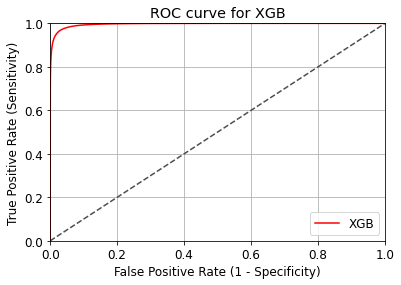

In [57]:
threshold = .5

y_pred_threshold     = (y_pred_proba_pos>threshold).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, y_pred_proba_pos)

plot_roc_curve(fpr, tpr, label="XGB");
#plt.show()

print('AUC     : {:2.5f} '.format(metrics.roc_auc_score(y, y_pred_proba_pos) ))
print('F1-score: {:2.5f}'.format(metrics.f1_score(y, (y_pred_proba_pos>.5))))
print('F1-score: {:2.5f} threshold({:2.2f})'.format(metrics.f1_score(y, y_pred_threshold), threshold))

## 3.2.2. Calibração do XBG

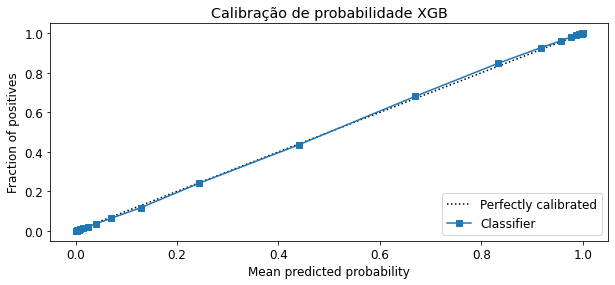

In [58]:
plt.figure(figsize=(10, 4))

y_pred_proba_pos = df_proba['y_proba']

CalibrationDisplay.from_predictions(y, y_pred_proba_pos, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Calibração de probabilidade XGB')
plt.show()

# 4. Gerar sumission 

In [61]:
submission_csv['target']= y_pred_test_prob_oof

In [63]:
submission_csv.head()

,id,target
0,900000,9.999941e-01
1,900001,9.999126e-01
2,900002,2.966688e-12
3,900003,1.257945e-04
4,900004,9.989915e-01


In [65]:
submission_csv.to_csv('Data/submission/xgb_01_score_0.99607.csv', index=False)

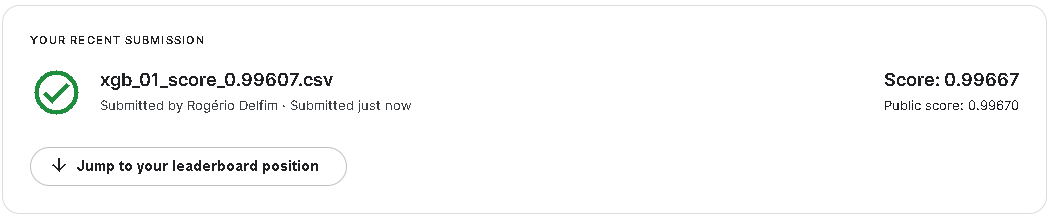